## Loading packages and setting up Jupyter notebook

In [1]:
import pdb 
import glob

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
 
import missingno  # for visualizing missing data

In [2]:
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set seaborn options
sns.set()
# sns.set_context("notebook") 

In [3]:
#mpl.rcParams['figure.figsize'] = (10.0, 10.0) 

## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [4]:
!head -2 data_raw/*.csv

==> data_raw/LoanStats3a_securev1.csv <==
Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","fico_range_low","fico_range_high","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","last_fico_range_high","last_fico_range_low","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_jo

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

# Importing data

In [5]:
# Get all the csv files in the data directory
files = glob.glob('data_raw/*.csv')

# Read those files into pandas
df_list = [pd.read_csv(file, header=1, low_memory=False) for file in files]

# Concatenate them into one DataFrame
all_data = pd.concat(df_list, ignore_index=True) 

# Get rid of the individual DataFrames
del df_list 

# Exploratory Data Analysis
Let's start with the dimension of our data set.

In [6]:
all_data.shape

(1873317, 151)

This reveals that we have about 1.8 million observations and 151 columns. Thus, let's start by getting rid of irrelevant observations and columns. We will then take a look at missing values in order to decide whether to impute them or to drop the whole column. 

Subsequently, we will explore how important loan outcomes have changed over time, and if we should discard data from the earliest years if it is too different from later observations. Once this is completed, we have arrived at the final set of observations and variables for the analysis, and we can start to explore distributions of individual variables as well as continue to explore relationship amongst other other variables.

## Dropping Duplicats
First let's look if there are any duplicats in the data:

In [7]:
all_data.duplicated().sum()

0

No duplicats were found, so we don't have to take any action.

## Dropping irrelevant observations
To zoom in on only the relevant observation, let us take a look at the variable of interest, loan_status. This will allow us to filter out cases where the outcome is ambiguous:

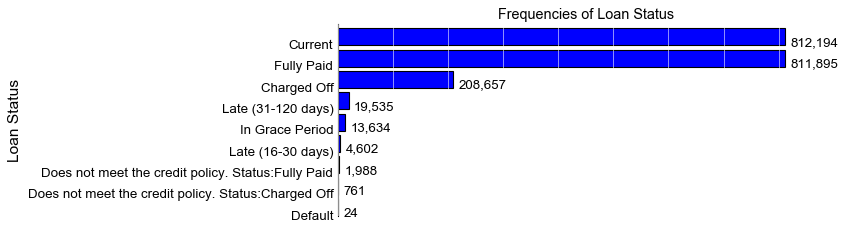

In [8]:
# sns.reset_defaults()
with plt.style.context('classic'): # Discard Seaborn defaults

    counts = all_data.loan_status.value_counts(ascending=True)  
    ind = np.arange(len(counts))  # y-axis

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.barh(y=ind, width=counts)

    ax.set_title("Frequencies of Loan Status", fontsize=13)
    # ax.set_xlabel("Frequencies of Loan Status", fontsize=14)
    ax.set_ylabel("Loan Status", fontsize=14)

    ax.set_yticks(ind)  # Get rid of extra ticks on top and bottom
    ax.set_yticklabels(counts.index)
    
    fig.patch.set_facecolor('w')  # Change background color to white  
    ax.grid(axis='x', color='white', linestyle='-')
    sns.despine(bottom=True)
    ax.tick_params(axis='both', which='both',length=0, labelsize=12, labelbottom=False)
    # ax.tick_params(axis='bottom', labelsize = 0)
    for y_position, count in zip(ind, counts):  # Add frequencies
        plt.annotate(format(count, ','), xy=(count+10000, y_position))

plt.show()

As the above figure shows, the vast majority of loans fall into 3 classes: Loans that are still current, Loans that were paid back completely, and loans that were written-off (i.e., loans are unlikely to be paid back). Only a small fraction of loans (in fact, only 24, too small to be visible in the graph) are categorized as defaults (meaning that we can be certain that they won't be paid back). Furthermore, there is a small number of loans for which the status variable contains the string "does not meet the credit policy" in addition to whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what exactly this means. I will simply treat them as fully paid or charged off, and ignore the information about not meeting the credit policy, which seems to be a separate variable. However, I do not use it for prediction, because it is likely that this information only became available after the loan was issued (since presumably the loan would not have been issued if it had been known at the time that the borrower did not meet the credit policy).    

The main question we need to decide is what exactly we want to predict.  I opt for a dichotomous classification into "fully paid" versus "charged off" and "default". For simplicity sake, I will call those "good" loans and "bad" loans. Note that those two classes are imbalanced.

Loans which are late – from still being in the grace period to up to 120 days late – will be discarded, because their status is yet indeterminate.  We have enough observations already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to the greater measurement error, because we do not have enough information yet to accurately classify them.

For similar reasons, I will discard loans that are still current.

In [9]:
# Create target variable (good or bad loans)
all_data['good'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'good'] = 1  # "Good" loans
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'good'] = 0  # "Bad"

In [10]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.good.notnull(),:]

## Indexing and Sorting Data
A natural index for the data is the "id" column. But first we need to make sure that it doesn't have any missing values.

In [11]:
all_data.id.isnull().sum()

0

It doesn't have any missing values, so we can use it. However, it would also be good to additionally index the data by time, so that we can sort and later potentially slice them by time. (Amongst other, this will come in handy later when looking at missing values, because we want to know if certain variables were simply not collected during certain time periods, or if they are missing for other reasons.)

The data dictionary lists several candidates for the time index (from the time the borrower applied, to the time they accepted the offer), but unfortunately none of these variables are actually contained in the data. Upon further inspection it appears that several of the column names were changed but were not updated in the data dictionary. Thus, let's take a look at all the column names and see if any sound like they contain a relevant date:

In [12]:
list(all_data.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

The only potential date variable for the loan start date is "issue_d", presumably the issue date of the loan. Let's take a look how it's formatted, so we can more effectively parse it:

In [13]:
all_data.loc[:, 'issue_d'].head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

Now we can set the issue date and loan ID as a hierarchical index, and then sort the data by date:

In [14]:
all_data['issue_d'] = pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y')

In [15]:
all_data = all_data.set_index(['issue_d', 'id']).sort_index()

## Dropping irrelevant columns

Now that we have discarded irrelevant rows, let's discard irrelevant columns. Since we are starting with about 150 columns, this will make the EDA easier.

### Dropping constant or all-missing columns
Let's start by deleting columns which are either constant or for which all observations are missing:

In [16]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 
print('Columns to be deleted:\n{}'.format(constant_or_missing))

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

Columns to be deleted:
['member_id', 'pymnt_plan', 'policy_code', 'hardship_flag', 'hardship_type', 'deferral_term', 'hardship_length']


### Dropping endogenous columns
It is also important that we drop columns that contain information that was not available at the time the loan was issued (e.g., how much money the borrower has paid back so far). Needless to say, failing to do so could give us an unfair edge if we included any of these variables in our model. (In the language of statistics, they are endogenous to our model since they are part of what we want to explain rather than part of what we can use for the explanation.)

Our first candidates for deletion are a number of date columns that I encountered when looking for the loan issue date. 

In [17]:
# Print further date columns
other_dates = all_data.columns[all_data.columns.str.contains("date", case=False)]
print(other_dates)

Index(['hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date',
       'settlement_date'],
      dtype='object')


## Missing Values
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

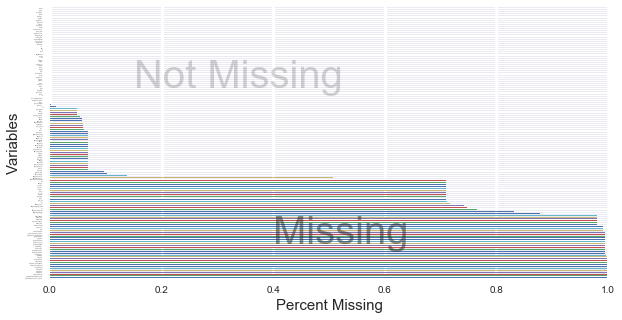

In [18]:
# Calculate the proportion of missing values for each variable
missing = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)

# Plot proportion of missing values for each variable 
missing.plot(kind="barh", figsize=(10, 5))
plt.xlim(0, 1)
plt.xlabel('Percent Missing', fontsize=15)
plt.ylabel('Variables', fontsize=15)
plt.tick_params(axis='y', length=0, labelsize = 0)
plt.grid(color="white", axis='x', linewidth=3)
plt.text(x=.15, y=100, s='Not Missing', fontsize=40, alpha=.2)
plt.text(x=.4, y=18, s='Missing', fontsize=40, alpha=.5)

plt.show()

Let us first focus on the big picture not worry about any individual variables. This reveals reveals an interesting pattern: Most variables cluster into groups with either no missing values (about a third of the variables), around 10% missing values (about a quarter), around 70% missing values (roughly 10% of variables), or almost all missing values (about a third of variables).

The fact that there are no variables that have between 15% and 65% missing values makes it easier for us to decide at what proportion of missing values we should draw a cut-off between dropping a variable and imputing missing values. I will choose 30% missing as the threshold, but any threshold between around 15% and around 65% would yield identical results.
    
This pattern could be due to the fact that, at certain points in time, additional batches of variables were starting to be collected. To look into this, let's aggregate the proportion of missing values by month and look for a time trend.

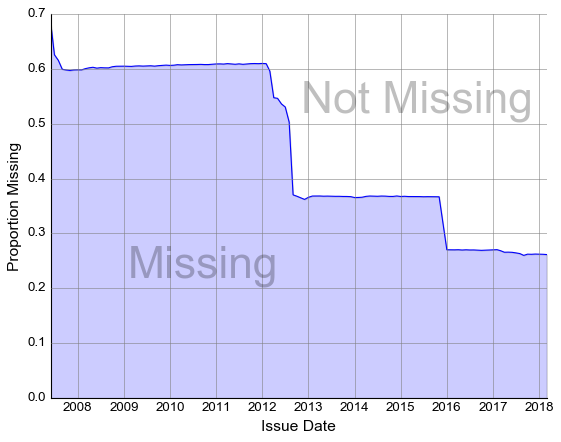

In [19]:
# Group-by month and calculate percentage of missing values
missing_by_year = all_data.groupby('issue_d').apply(lambda x: x.isnull().sum().sum()/(x.shape[0]*x.shape[1]))

with plt.style.context('classic'): # Discard Seaborn defaults
    fig, ax = plt.subplots()

    ax.plot(missing_by_year)
    ax.set(xlim=(min(missing_by_year.index), max(missing_by_year.index)), 
           ylim=(0, .7)) 
    ax.set_ylabel('Proportion Missing', fontsize=14)
    ax.set_xlabel('Issue Date', fontsize=14)
            
    ax.tick_params(length=0) 
    ax.fill_between(missing_by_year.index, 0, missing_by_year.values, alpha=.2)
    ax.grid(color='grey', linestyle='-')
    fig.patch.set_facecolor('w')       
    sns.despine()
    plt.text(x=missing_by_year.index[20], y=.22, s='Missing', fontsize=40, alpha=.25)
    plt.text(x=missing_by_year.index[65], y=.52, s='Not Missing', fontsize=40, alpha=.25)
    
plt.show()

It does indeed look like over time more and more variables were collected, and that these additional columns were for the most part added during three distinct time periods: In mid-2007 (only a few months after the first observations were collected), in 2012, and in late-2015.

To verify that it is in fact the same variables that are missing for a particular time period, we need to disaggregate these results by individual variables. If this shows that a particular variable has missing values that are distributed relatively evenly through time, we need to take a 2nd look at the meaning of the variable before dropping it to make sure that missingness does not simply denote that a variable is not applicable.  Obviously, if that was the case, there is no reason to drop it because it is not really missing – though we do have to find a way how to properly encode it. 
Conversely, if missingness for a particular variable mainly stems from the fact that it's observations were not collected during a substantial part of our sample period, we know that we can safely discard it. 

In the plot below, only variables that have at least one missing observation will be shown . Unfortunately, we still have too many columns to display the names of individual columns, so let's just focus on the big picture and plot smaller subsets later. Each column denotes a particular variable, and each row denotes an observation, ordered from earliest (top) to latest (bottom). Missing values are plotted as white, and non-missing values are plotted as black.  On the very right, there is a line graph that is supposed to show the number of non-missing values for each observation (ranging from 43 to 134), but due to the large number of observations graphed here, it is not very useful and can safely be ignored. 

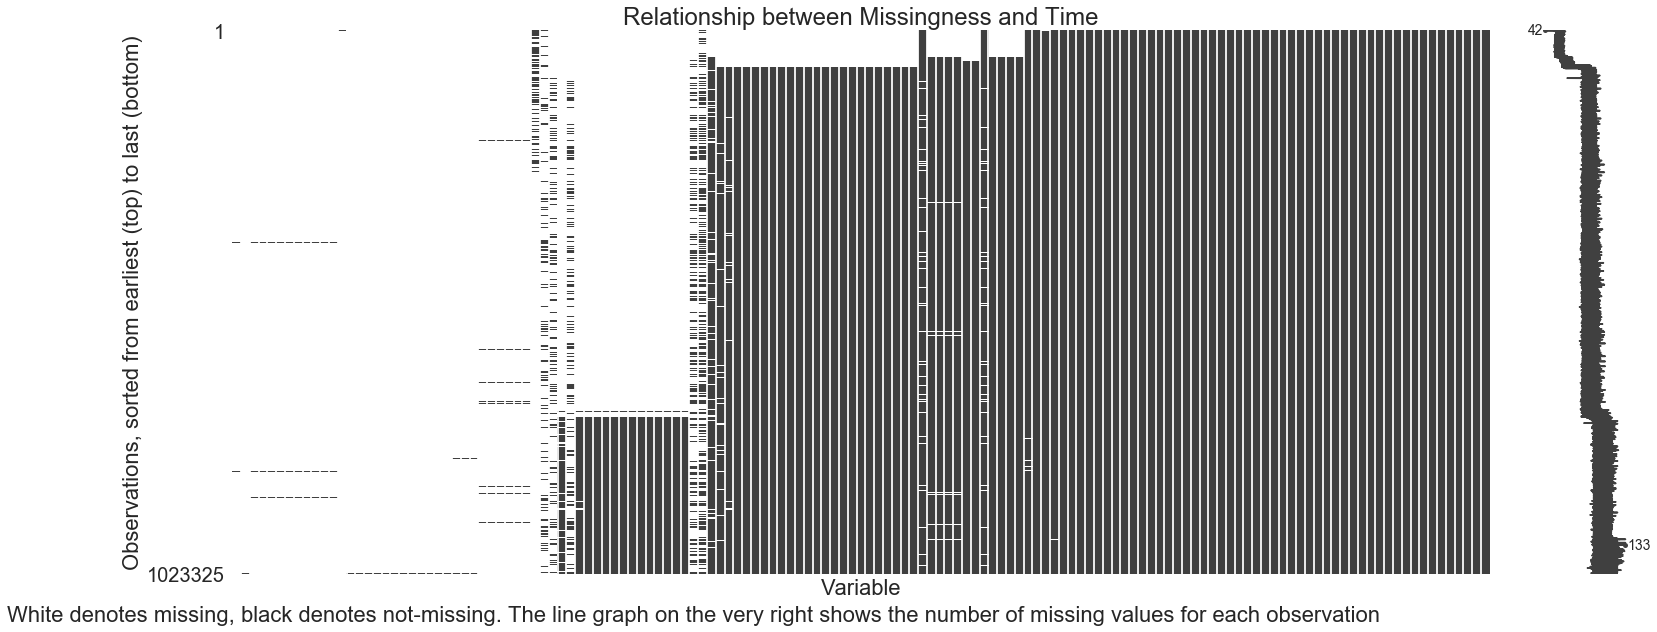

In [20]:
# Plot missing data
missingno.matrix(all_data.loc[:, missing.index])
plt.title('Relationship between Missingness and Time', \
          fontsize=24)
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize=22)
plt.xlabel('Variable', fontsize=22)
plt.figtext(x=0, y=.06, s="White denotes missing, black denotes not-missing. The line graph on the very right "
            "shows the number of missing values for each observation", fontsize=22)
plt.show();

This reveals that – with a few notable exceptions – most of the missingness is indeed caused by the fact that many variables were not collected over the whole sample period. At the same time, there are also a few variable with a substantial proportion of missing values that are distributed relatively evenly across time.

In order to be able to display the variable names, we need to split the variables up into several plots. Let's start with those variables that have the highest proportion of missingness: 

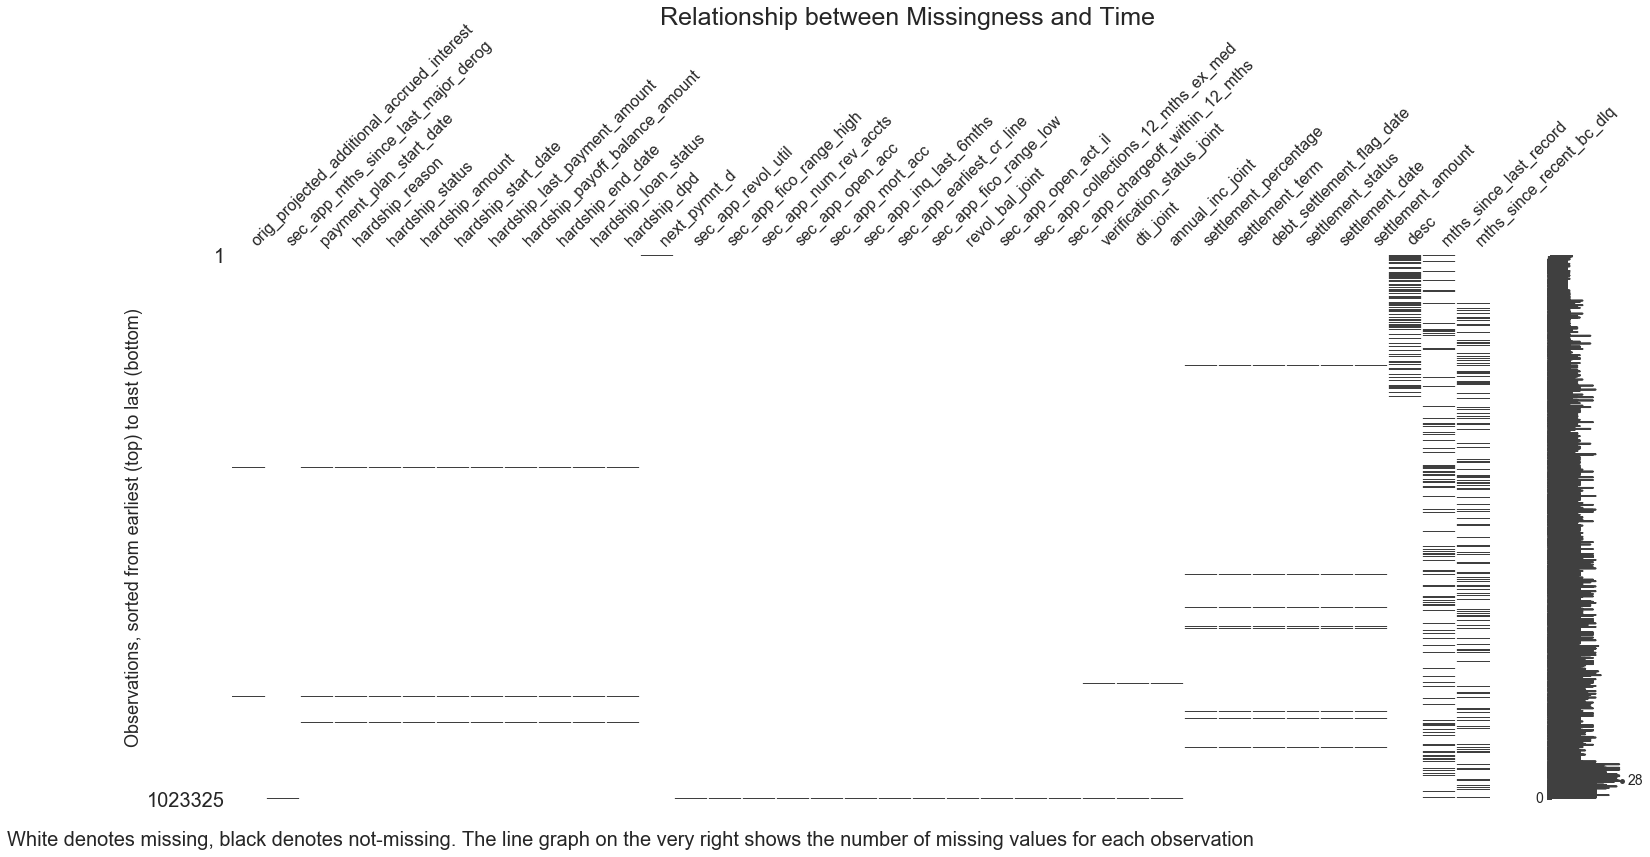

In [21]:
# Note that I don't explicitly exclude columns that have no missing values, because those will 
# automatically be discarded as irrelevant by missingno.
variables_to_plot_1 = missing[missing>.75].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_1])
plt.figtext(x=.5, y=1.2, s='Relationship between Missingness and Time', 
            fontsize=25, horizontalalignment='center')
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.figtext(x=0, y=.06, s='White denotes missing, black denotes not-missing. The line graph on the very right '
            'shows the number of missing values for each observation', fontsize=20)
plt.show();

Most of these variables can safely be discarded since they were only collected for part of the sample period. The exceptions are the two rightmost variable, for which missingness is distributed relatively evenly across time. Thus, we will add them to a list of variables which to inspect later to make sure missingness doesn't actually stand for not applicable.

In [22]:
# Create a list of variables to inspect later, and add the last two variables
variables_to_inspect = list(variables_to_plot_1[-2:])

# Create a list of variables to delete, and at all the plotted variables except the last two
variables_to_delete = list(variables_to_plot_1[:-2])
variables_delete = [variable for variable in variables_to_plot_1 if variable not in variables_to_inspect]

Now let's plot the remaining variables for which at least half of the values are missing. 

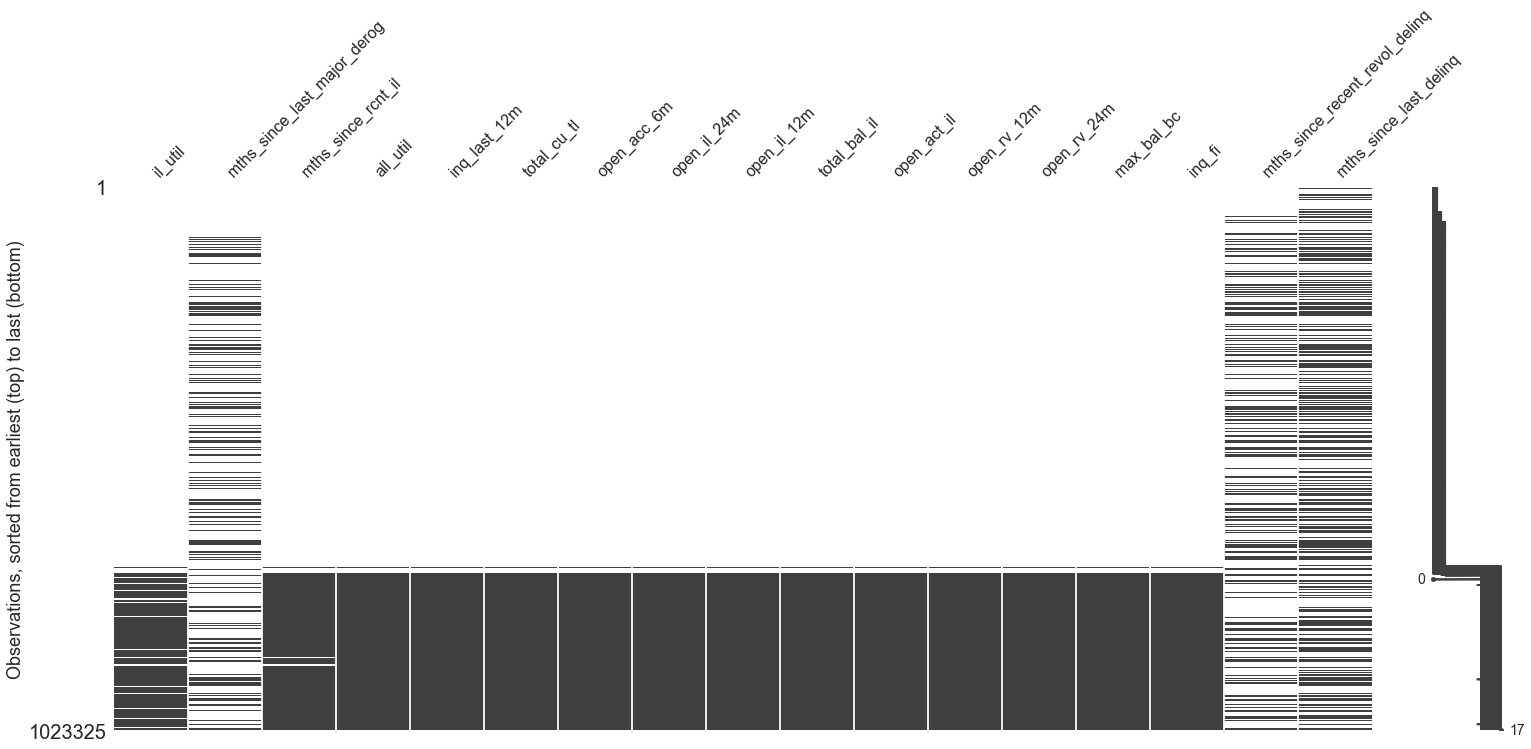

In [23]:
variables_to_plot_2 = missing[(missing <= .75) & (missing > .5)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_2])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.show();

Again, most of these variables were only collected for the last portion of the sample time, so we will discard them. However, for three variables missingness is distributed relatively evenly across time, so we will add them to the list of variables to inspect later.

In [24]:
# Add variables to list of variables to inspect later
variables_to_inspect.extend(['mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
                            'mths_since_last_delinq'])

# Add variables to list of variables to delete
variables_to_delete.extend([v for v in variables_to_plot_2 if v not in variables_to_inspect])

Finally, let's plot missingness for variables that have less than 50% missing values. (We will ignore variables that have less than 0.5% missing values, because this is close enough to zero for our purposes to not cause any problems, and this reduces the number of variables enough to fit into one plot.)

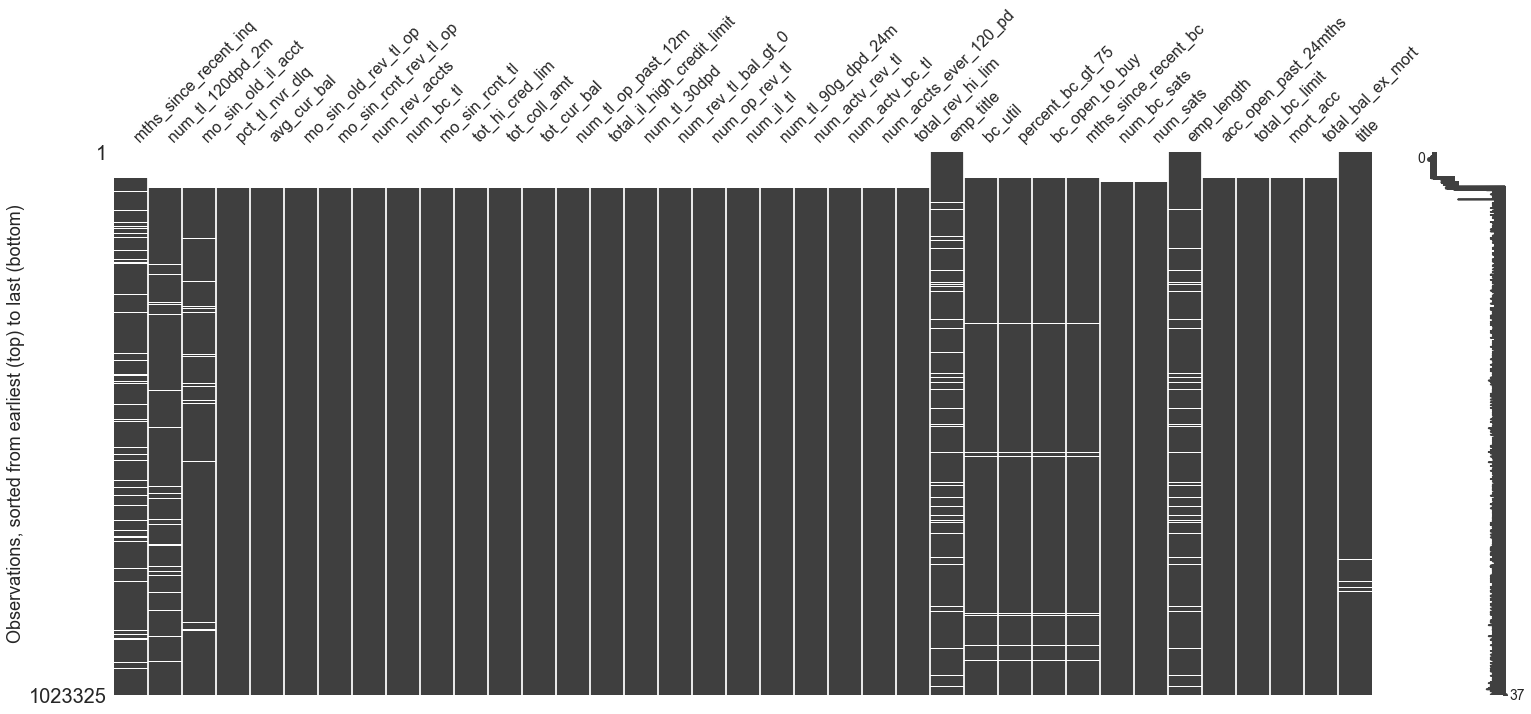

In [25]:
variables_to_plot_3 = missing[(missing < .50) & (missing > .005)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_3])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.show();

While for some of these variables were not collected at the very beginning of the sample periods, there is no need to drop them because the number of missing values (around 10%) is small enough to be imputed fairly reliably. (Furthermore, as we will see below, the earliest observations will be discarded from the sample anyway because Lending Club's business model was still in flux during its first years.)

Let us now inspect the variables we have singled out, to see whether missingness simply stands for "not applicable". Let's first print their names:

In [26]:
variables_to_inspect

['mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq']

This shows that all five variables referr to the number of months since a specific event that does not apply to all borrowers (e.g., experiencing a delinquency) happened. This explains why missingness for those variables is distributed relatively evenly across time. For those borrowers to which the particular event does not apply, the time since this event is encoded as missing. Unfortunately, there is no value in Python that stands for "not applicable", so we will leave these values encoded as missing and decide on a better strategy once we know how exactly we are going to incorporate these variables into our model.

Since we decided not to drop any of these variables, our list of variables to drop is now complete, so let's go ahead and get rid of them:

In [27]:
# Drop variables with too many missing values
all_data = all_data.drop(variables_to_delete, axis=1)

#Print number of deleted variables
'{} variables were dropped'.format(len(variables_to_delete))

'49 variables were dropped'

#  Identifying Outliers

Boxplot